In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

c:\python3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\python3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(train.columns)
print()
print(train.head())

Index(['id', 'label', 'province', 'district', 'age_source1', 'age_source2',
       'maCv', 'FIELD_1', 'FIELD_2', 'FIELD_3', 'FIELD_4', 'FIELD_5',
       'FIELD_6', 'FIELD_7', 'FIELD_8', 'FIELD_9', 'FIELD_10', 'FIELD_11',
       'FIELD_12', 'FIELD_13', 'FIELD_14', 'FIELD_15', 'FIELD_16', 'FIELD_17',
       'FIELD_18', 'FIELD_19', 'FIELD_20', 'FIELD_21', 'FIELD_22', 'FIELD_23',
       'FIELD_24', 'FIELD_25', 'FIELD_26', 'FIELD_27', 'FIELD_28', 'FIELD_29',
       'FIELD_30', 'FIELD_31', 'FIELD_32', 'FIELD_33', 'FIELD_34', 'FIELD_35',
       'FIELD_36', 'FIELD_37', 'FIELD_38', 'FIELD_39', 'FIELD_40', 'FIELD_41',
       'FIELD_42', 'FIELD_43', 'FIELD_44', 'FIELD_45', 'FIELD_46', 'FIELD_47',
       'FIELD_48', 'FIELD_49', 'FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53',
       'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57'],
      dtype='object')

   id  label               province               district  age_source1  \
0   0      0                    NaN                    NaN          NaN 

In [4]:
train_cols = [col for col in train.columns if col not in ['id', 'maCv', 'province', 'district', 'label', 'FIELD_7']]
# train_cols = [col for col in train.columns if col not in ['label']]

In [5]:
category_cols = [col for col in train_cols if str(train[col].dtypes) == 'object']
print(category_cols)
print(len(category_cols))
print(train[category_cols].head())

['FIELD_8', 'FIELD_9', 'FIELD_10', 'FIELD_11', 'FIELD_12', 'FIELD_13', 'FIELD_17', 'FIELD_18', 'FIELD_19', 'FIELD_20', 'FIELD_23', 'FIELD_24', 'FIELD_25', 'FIELD_26', 'FIELD_27', 'FIELD_28', 'FIELD_29', 'FIELD_30', 'FIELD_31', 'FIELD_35', 'FIELD_36', 'FIELD_37', 'FIELD_38', 'FIELD_39', 'FIELD_40', 'FIELD_41', 'FIELD_42', 'FIELD_43', 'FIELD_44', 'FIELD_45']
30
  FIELD_8 FIELD_9 FIELD_10 FIELD_11 FIELD_12 FIELD_13 FIELD_17 FIELD_18  \
0     NaN      na      NaN      NaN      NaN      NaN      NaN      NaN   
1    MALE      GD       T1       12     None       BI       G8     True   
2  FEMALE      DN       T1       12        0       YN     None    False   
3     NaN      na      NaN      NaN      NaN      NaN      NaN      NaN   
4    MALE      GD       T1       12     None       BI       G8     True   

  FIELD_19 FIELD_20  ... FIELD_36 FIELD_37 FIELD_38 FIELD_39 FIELD_40  \
0      NaN      NaN  ...      NaN      NaN      NaN      NaN      NaN   
1     True     True  ...    FALSE     Tru

In [6]:
number_cols = [col for col in train_cols if str(train[col].dtypes) == 'float64']
print(number_cols)
print(len(number_cols))
print(train[number_cols].head())

['age_source1', 'age_source2', 'FIELD_2', 'FIELD_3', 'FIELD_4', 'FIELD_5', 'FIELD_6', 'FIELD_16', 'FIELD_21', 'FIELD_22', 'FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53', 'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57']
18
   age_source1  age_source2  FIELD_2  FIELD_3  FIELD_4  FIELD_5  FIELD_6  \
0          NaN          NaN      1.0   2547.0      0.0      0.0      0.0   
1         44.0         44.0      0.0     -1.0      1.0      1.0      1.0   
2         30.0         30.0      1.0   3273.0      1.0      4.0      0.0   
3         43.0          NaN      1.0   3991.0      1.0      1.0      0.0   
4         21.0         21.0      1.0   1450.0      0.0      2.0      0.0   

   FIELD_16  FIELD_21  FIELD_22  FIELD_50  FIELD_51  FIELD_52  FIELD_53  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       2.0       1.0       4.0     29.77    17.561    30.955    31.171   
2       1.0       1.0      54.0     29.77    56.512    30.955    31.171   
3       NaN       NaN 

In [7]:
# fill NA
for col in category_cols:
    train[col] = train[col].fillna('NaN')
    train[col] = train[col].replace(['None', 'none', 'nan', 'na'])

for col in number_cols:
    train[col] = train[col].fillna(-2.0)


In [8]:
# add bool feature to category feature
# boolean from float64
category_cols.append('FIELD_2')
train['FIELD_2'] = train['FIELD_2'].map({-2.0: 'NaN', 0.0: 'False', 1.0: 'True'})
# boolean from int64
int64_cols = [col for col in train_cols if str(train[col].dtypes) == 'int64']
category_cols += int64_cols
for col in int64_cols:
    train[col] = train[col].map({0 : 'False', 1: 'True'})


In [9]:
category_cols

['FIELD_8',
 'FIELD_9',
 'FIELD_10',
 'FIELD_11',
 'FIELD_12',
 'FIELD_13',
 'FIELD_17',
 'FIELD_18',
 'FIELD_19',
 'FIELD_20',
 'FIELD_23',
 'FIELD_24',
 'FIELD_25',
 'FIELD_26',
 'FIELD_27',
 'FIELD_28',
 'FIELD_29',
 'FIELD_30',
 'FIELD_31',
 'FIELD_35',
 'FIELD_36',
 'FIELD_37',
 'FIELD_38',
 'FIELD_39',
 'FIELD_40',
 'FIELD_41',
 'FIELD_42',
 'FIELD_43',
 'FIELD_44',
 'FIELD_45',
 'FIELD_2',
 'FIELD_1',
 'FIELD_14',
 'FIELD_15',
 'FIELD_32',
 'FIELD_33',
 'FIELD_34',
 'FIELD_46']

In [10]:
train.head()

,id,label,province,district,age_source1,age_source2,maCv,FIELD_1,FIELD_2,FIELD_3,...,FIELD_48,FIELD_49,FIELD_50,FIELD_51,FIELD_52,FIELD_53,FIELD_54,FIELD_55,FIELD_56,FIELD_57
0,0,0,NaN,NaN,-2.0,-2.0,NaN,True,True,2547.0,...,True,True,-2.00,-2.000,-2.000,-2.000,-2.0,-2.00,-2.0,-2.0
1,1,0,Tỉnh Đồng Nai,Thành phố Biên Hòa,44.0,44.0,None,True,False,-1.0,...,False,True,29.77,17.561,30.955,31.171,0.0,0.04,0.0,0.0
2,2,0,Tỉnh Đồng Nai,Huyện Long Thành,30.0,30.0,Công nhân,False,True,3273.0,...,True,True,29.77,56.512,30.955,31.171,0.0,0.16,0.0,0.0
3,3,0,Tỉnh Tuyên Quang,Thành phố Tuyên Quang,43.0,-2.0,NaN,False,True,3991.0,...,True,False,-2.00,-2.000,-2.000,-2.000,-2.0,-2.00,-2.0,-2.0
4,4,0,Thành phố Hồ Chí Minh,Quận 1,21.0,21.0,None,False,True,1450.0,...,True,True,29.77,13.789,30.955,31.171,0.0,0.03,0.0,0.0


In [11]:
print(train['FIELD_35'].value_counts())
print(train['FIELD_41'].value_counts())
print(train['FIELD_42'].value_counts())
print(train['FIELD_44'].value_counts())


NaN      9678
Zero     9210
One      4472
Four     4056
Two      1366
Three    1218
Name: FIELD_35, dtype: int64
I      12936
NaN     9678
V       4860
II      1146
III      737
IV       643
Name: FIELD_41, dtype: int64
Zezo    20165
NaN      9678
One       157
Name: FIELD_42, dtype: int64
One    14867
NaN     9687
Two     5446
Name: FIELD_44, dtype: int64


In [12]:
# mapping order feature
dict_map = {'NaN': -1,
           'Zero': 0,
           'One':1,
           'Two':2,
           'Three':3,
           'Four':4}
train['FIELD_35_number'] = train['FIELD_35'].map(dict_map)

dict_map = {'NaN': -1,
           'I': 1,
           'II':2,
           'III':3,
           'IV':4,
           'V':4}
train['FIELD_41_number'] = train['FIELD_41'].map(dict_map)

dict_map = {'NaN': -1,
           'Zezo': 0,
           'One':1}
train['FIELD_42_number'] = train['FIELD_42'].map(dict_map)

dict_map = {'NaN': -1,
           'One':1,
           'Two':2}
train['FIELD_44_number'] = train['FIELD_44'].map(dict_map)

# remove order cate feature from category feature

In [13]:
train_cols += ['FIELD_35_number', 'FIELD_41_number', 'FIELD_42_number', 'FIELD_44_number']

In [14]:
for col in category_cols:
    try:
        dict_map = dict(train[col].value_counts())
    except:
        continue
    train[col+'_FREQ'] = train[col].map(dict_map)
    if str(col+'_FREQ') not in train_cols:
        train_cols.append(col+'_FREQ')

In [15]:
train['FILED_3_by_day'] = train['FIELD_3'].apply(lambda x : x % 365)
train_cols.append('FILED_3_by_day')


In [16]:
train['FIELD5052'] = abs(train['FIELD_50']-train['FIELD_52'])
train['FIELD5053'] = abs(train['FIELD_50']-train['FIELD_52'])
train['FIELD5253'] = abs(train['FIELD_52']-train['FIELD_52'])
train_cols += ['FIELD5253', 'FIELD5053', 'FIELD5052']

In [17]:
# train['FIELD_8_FREQ']

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
le = LabelEncoder()
for column in category_cols:
    train[column] = train[column].astype(str)
    train[column] = le.fit_transform(train[column].astype(str))

In [20]:
# for column in category_cols:
#     train[column] = train[column].astype(str)

In [21]:
# train = train.fillna(-1)

In [22]:
print(train[train_cols].info())
print(train_cols)
print()
print(category_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 103 entries, age_source1 to FIELD5052
dtypes: bool(3), float64(21), int32(38), int64(41)
memory usage: 18.6 MB
None
['age_source1', 'age_source2', 'FIELD_1', 'FIELD_2', 'FIELD_3', 'FIELD_4', 'FIELD_5', 'FIELD_6', 'FIELD_8', 'FIELD_9', 'FIELD_10', 'FIELD_11', 'FIELD_12', 'FIELD_13', 'FIELD_14', 'FIELD_15', 'FIELD_16', 'FIELD_17', 'FIELD_18', 'FIELD_19', 'FIELD_20', 'FIELD_21', 'FIELD_22', 'FIELD_23', 'FIELD_24', 'FIELD_25', 'FIELD_26', 'FIELD_27', 'FIELD_28', 'FIELD_29', 'FIELD_30', 'FIELD_31', 'FIELD_32', 'FIELD_33', 'FIELD_34', 'FIELD_35', 'FIELD_36', 'FIELD_37', 'FIELD_38', 'FIELD_39', 'FIELD_40', 'FIELD_41', 'FIELD_42', 'FIELD_43', 'FIELD_44', 'FIELD_45', 'FIELD_46', 'FIELD_47', 'FIELD_48', 'FIELD_49', 'FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53', 'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57', 'FIELD_35_number', 'FIELD_41_number', 'FIELD_42_number', 'FIELD_44_number', 'FIELD_8_FREQ', 'FIELD_9_FRE

In [23]:
# # one hot encoding
# for col in category_cols:
#     one_hot = pd.get_dummies(train[col], prefix=col)
#     # Drop column B as it is now encoded
#     train = train.drop(col,axis = 1)
#     # Join the encoded df
#     train = train.join(one_hot)
#     one_hot = pd.get_dummies(train[col], prefix=col)
#     # Drop column B as it is now encoded
#     train = train.drop(col,axis = 1)
#     # Join the encoded df
#     train = train.join(one_hot)
# #     le = preprocessing.LabelEncoder()
# #     le.fit(train[col].astype(str))
# #     train[col] = le.transform(train[col].astype(str))
# print(train.columns)
# print()
# print(train.head())

In [24]:
train_cols.remove('FIELD_13')
category_cols.remove('FIELD_13')

In [25]:
train_y = train.label
train.drop(columns=['label'])
train_X = train[train_cols]

In [26]:
len(train_cols)

102

In [27]:
# train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,test_size=0.4, random_state=0)

In [28]:
# # training model
# params={
#     'seed': 0,
#     'colsample_bytree': 0.7,
#     'silent': 1,
#     'subsample': 0.7,
#     'learning_rate': 0.075,
#     'objective': 'binary:logistic',
#     'max_depth': 4,
#     'num_parallel_tree': 1,
#     'min_child_weight': 1,
#     'nrounds': 200
#     }

# clf = XGBClassifier(**params)
# clf.fit(train_X, train_y, \
#         eval_set=[(train_X, train_y), (val_X, val_y)], \
#                   eval_metric='auc', early_stopping_rounds = 50)

In [29]:
num_round = 10000
kfold = 5
folds = StratifiedKFold(n_splits=kfold, shuffle=False, random_state=44000)
oof = np.zeros(len(train_X))
# predictions = np.zeros(len(test_df))

In [30]:
param = {'boosting': 'gbdt',
          'metric': 'auc',
          'objective': 'binary',
          'num_leaves': 5,
          'min_data_in_leaf': 198,
          'max_depth': 30,
          'learning_rate': 0.005,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17
          }
score_arr = np.zeros(kfold)
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values, train_y.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_X.iloc[trn_idx][train_cols], label=train_y.iloc[trn_idx], categorical_feature=category_cols)
    val_data = lgb.Dataset(train_X.iloc[val_idx][train_cols], label=train_y.iloc[val_idx], categorical_feature=category_cols)
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=500, categorical_feature=category_cols)
    oof[val_idx] = clf.predict(train_X.iloc[val_idx][train_cols], num_iteration=clf.best_iteration)
    score_arr[fold_] = roc_auc_score(train_y.iloc[val_idx], oof[val_idx])
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_cols
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(np.mean(score_arr)))

Fold 0
Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.665546	valid_1's auc: 0.612772
[200]	training's auc: 0.67819	valid_1's auc: 0.615144
[300]	training's auc: 0.691275	valid_1's auc: 0.615781
[400]	training's auc: 0.701505	valid_1's auc: 0.612664
[500]	training's auc: 0.711888	valid_1's auc: 0.614517
[600]	training's auc: 0.721251	valid_1's auc: 0.611423
[700]	training's auc: 0.730287	valid_1's auc: 0.607141
Early stopping, best iteration is:
[247]	training's auc: 0.684349	valid_1's auc: 0.620988
Fold 1
Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.669016	valid_1's auc: 0.574578
[200]	training's auc: 0.691241	valid_1's auc: 0.57938
[300]	training's auc: 0.703613	valid_1's auc: 0.582507
[400]	training's auc: 0.714186	valid_1's auc: 0.583045
[500]	training's auc: 0.721952	valid_1's auc: 0.583418
[600]	training's auc: 0.727634	valid_1's auc: 0.589765
[700]	training's auc: 0.733808	valid_1's auc: 0.595302
[800

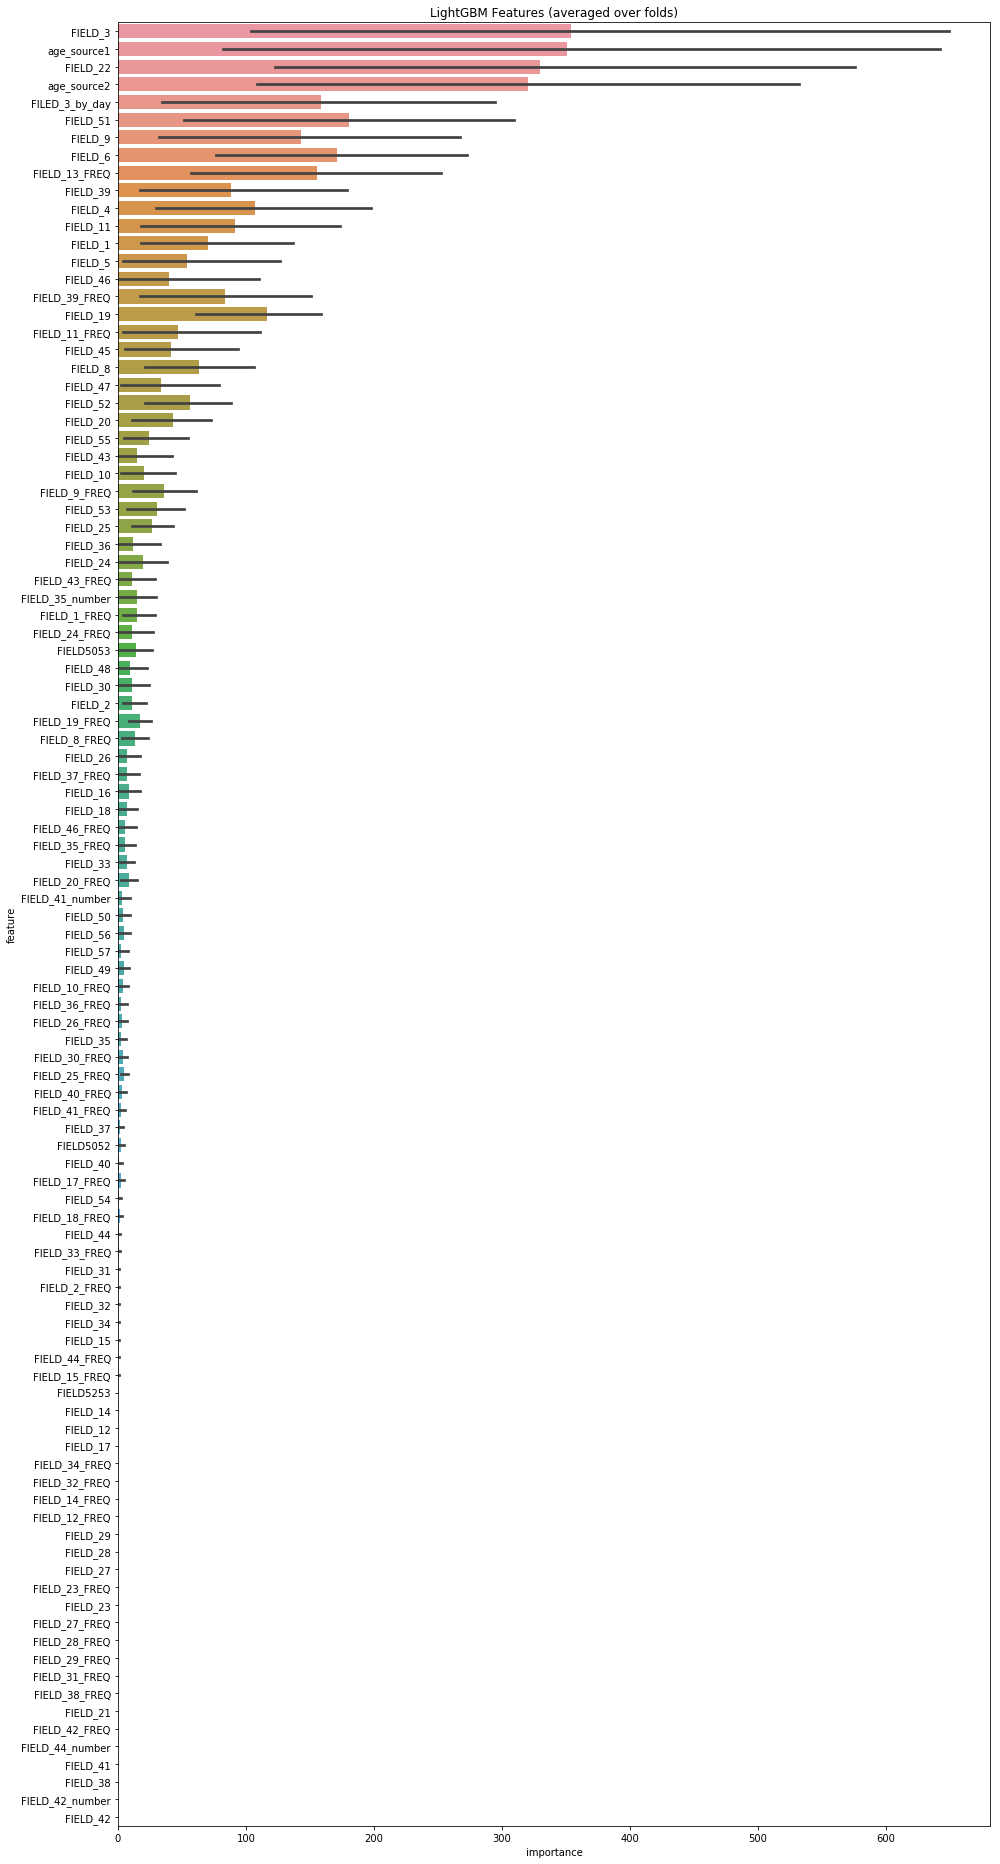

In [31]:

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [32]:
dict_count = train['FIELD_3'].value_counts()
sorted(dict_count.keys())


[-2.0,
 -1.0,
 337.0,
 338.0,
 339.0,
 340.0,
 341.0,
 342.0,
 343.0,
 344.0,
 345.0,
 346.0,
 347.0,
 348.0,
 349.0,
 350.0,
 351.0,
 352.0,
 353.0,
 354.0,
 355.0,
 356.0,
 357.0,
 358.0,
 359.0,
 360.0,
 361.0,
 362.0,
 363.0,
 364.0,
 365.0,
 366.0,
 367.0,
 702.0,
 703.0,
 704.0,
 705.0,
 706.0,
 707.0,
 708.0,
 709.0,
 710.0,
 711.0,
 712.0,
 713.0,
 714.0,
 715.0,
 716.0,
 717.0,
 718.0,
 719.0,
 720.0,
 721.0,
 722.0,
 723.0,
 724.0,
 725.0,
 726.0,
 727.0,
 728.0,
 729.0,
 730.0,
 731.0,
 732.0,
 1067.0,
 1068.0,
 1069.0,
 1070.0,
 1071.0,
 1072.0,
 1073.0,
 1074.0,
 1075.0,
 1076.0,
 1077.0,
 1078.0,
 1079.0,
 1080.0,
 1081.0,
 1082.0,
 1083.0,
 1084.0,
 1085.0,
 1086.0,
 1087.0,
 1088.0,
 1089.0,
 1090.0,
 1091.0,
 1092.0,
 1093.0,
 1094.0,
 1095.0,
 1096.0,
 1097.0,
 1433.0,
 1434.0,
 1435.0,
 1436.0,
 1437.0,
 1438.0,
 1439.0,
 1440.0,
 1441.0,
 1442.0,
 1443.0,
 1444.0,
 1445.0,
 1446.0,
 1447.0,
 1448.0,
 1449.0,
 1450.0,
 1451.0,
 1452.0,
 1453.0,
 1454.0,
 1455.0,
 145

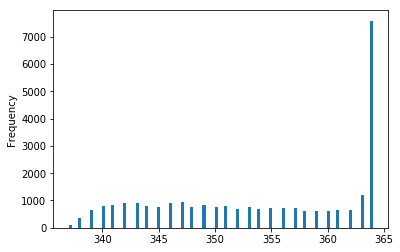

In [33]:
train[train['FILED_3_by_day'] > 10]['FILED_3_by_day'].plot.hist(bins=100)

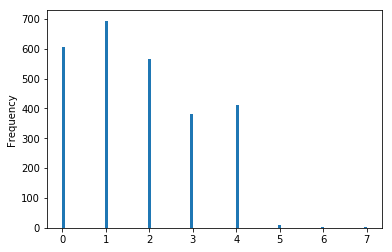

In [34]:
train[train['FILED_3_by_day'] < 10]['FILED_3_by_day'].plot.hist(bins=100)

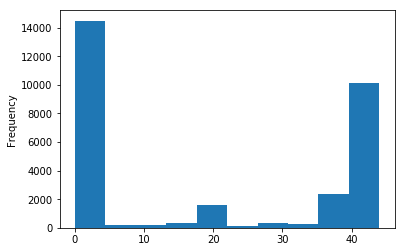

In [35]:
train['FIELD_11'].plot.hist()


In [38]:
train['FIELD_10'].value_counts()

2    10857
1     9678
0     9465
Name: FIELD_10, dtype: int64

In [36]:
# dict_count